Source : https://github.com/mdabashar/TAnoGAN 

## TAnoGAN: Time Series Anomaly Detection with Generative Adversarial Networks

Published in: 2020 IEEE Symposium Series on Computational Intelligence (SSCI)

Paper link: https://ieeexplore.ieee.org/abstract/document/9308512

### Import required libraries

In [1]:
import os
import json
import random
import torch
import pandas as pd
import torch.nn as nn
from collections import Counter
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torch.nn.init as init
from torch.autograd import Variable
import datetime
import warnings
warnings.filterwarnings('ignore')
from nab_dataset import NabDataset
from models.recurrent_models_pyramid import LSTMGenerator, LSTMDiscriminator

#### Define Basic Settings for Adversarial Training

In [2]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=20
    lr=0.0002
    cuda = True
    manualSeed=2
    
opt_trn=ArgsTrn()

In [3]:
torch.manual_seed(opt_trn.manualSeed)
cudnn.benchmark = True

### Setup Data Loader

In [4]:
# location of datasets and category
end_name = 'ambient_temperature_system_failure.csv' # dataset name
data_file = 'realKnownCause/realKnownCause/'+end_name # dataset category and dataset name
key = 'realKnownCause/'+end_name # This key is used for reading anomaly labels

In [5]:
# settings for data loader
class DataSettings:
    
    def __init__(self):
        self.BASE = 'C:/Users/today/Anormal Detection/data/NabDataset/'
        self.label_file = 'labels/combined_windows.json'
        self.data_file = data_file
        self.key = key
        self.train = True
        self.window_length = 60
    
    
data_settings = DataSettings()

In [6]:
# define dataset object and data loader object for NAB dataset
dataset = NabDataset(data_settings=data_settings)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))

dataset.x.shape, dataset.y.shape # check the dataset shape

(torch.Size([7207, 60, 1]), torch.Size([7207]))

### Dataset Example

In [7]:
pd.read_csv(data_settings.BASE + data_settings.data_file).tail(3)

timestamp      value
7264  2014-05-28 13:00:00  72.046565
7265  2014-05-28 14:00:00  71.825226
7266  2014-05-28 15:00:00  72.584089

In [8]:
with open(data_settings.BASE + data_settings.label_file, 'r') as f:
    json_data = json.load(f)
    
# 58개의 csv파일에 대한 이상치인 날짜에 대한 정보가 포함
print(len(json_data.keys()))

58


In [9]:
json_data['realKnownCause/ambient_temperature_system_failure.csv']

[['2013-12-15 07:00:00.000000', '2013-12-30 09:00:00.000000'],
 ['2014-03-29 15:00:00.000000', '2014-04-20 22:00:00.000000']]

- ['2013-12-15 07:00:00.000000', '2013-12-30 09:00:00.000000'] 사이에 속한 데이터는 모두 이상치이다. 
- ['2014-03-29 15:00:00.000000', '2014-04-20 22:00:00.000000'] 사이에 속한 데이터는 모두 이상치이다. 

In [10]:
Counter(dataset.y.tolist())

Counter({0.0: 6363, 1.0: 844})

- 총 7207개의 데이터 중 844개의 이상치가 존재

### Setup Models

In [11]:
#device = torch.device("cuda" if torch.cuda.is_available else "cpu") # select the device
device = 'cpu'
seq_len = dataset.window_length # sequence length is equal to the window length
in_dim = dataset.n_feature # input dimension is same as number of feature

In [14]:
print(seq_len)
print(in_dim)

60
1


In [12]:
# Create generator and discriminator models
netD = LSTMDiscriminator(in_dim=in_dim, device=device).to(device)
netG = LSTMGenerator(in_dim=in_dim, out_dim=in_dim, device=device).to(device)

In [13]:
print("|Discriminator Architecture|\n", netD)
print("|Generator Architecture|\n", netG)

|Discriminator Architecture|
 LSTMDiscriminator(
  (lstm): LSTM(1, 100, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
|Generator Architecture|
 LSTMGenerator(
  (lstm0): LSTM(1, 32, batch_first=True)
  (lstm1): LSTM(32, 64, batch_first=True)
  (lstm2): LSTM(64, 128, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Tanh()
  )
)


In [15]:
# Setup loss function
criterion = nn.BCELoss().to(device)

In [16]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt_trn.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opt_trn.lr)

### Adversarial Training of Generator and Discriminator Models

In [18]:
real_label = 1
fake_label = 0

for epoch in range(opt_trn.epochs):
    for i, (x,y) in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        #Train with real data
        netD.zero_grad()
        real = x.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        label = torch.full((batch_size, seq_len, 1), real_label, device=device)

        output,_ = netD.forward(real)
        errD_real = criterion(output, label.float())
        errD_real.backward()
        optimizerD.step()
        D_x = output.mean().item()
        
        #Train with fake data
        noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1))
        fake,_ = netG.forward(noise)
        output,_ = netD.forward(fake.detach()) # detach causes gradient is no longer being computed or stored to save memeory
        label.fill_(fake_label)
        errD_fake = criterion(output, label.float())
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1))
        fake,_ = netG.forward(noise)
        label.fill_(real_label) 
        output,_ = netD.forward(fake)
        errG = criterion(output, label.float())
        errG.backward()
        optimizerG.step()
        D_G_z2 = output.mean().item()
        
        

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
          % (epoch, opt_trn.epochs, i, len(dataloader),
             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2), end='')
    print()

[0/20][225/226] Loss_D: 0.7833 Loss_G: 0.7177 D(x): 0.9093 D(G(z)): 0.4901 / 0.4887
[1/20][225/226] Loss_D: 0.3843 Loss_G: 1.5322 D(x): 0.9226 D(G(z)): 0.2340 / 0.2339
[2/20][225/226] Loss_D: 0.2464 Loss_G: 2.4108 D(x): 0.9373 D(G(z)): 0.1350 / 0.1338
[3/20][225/226] Loss_D: 1.6311 Loss_G: 0.4915 D(x): 0.5735 D(G(z)): 0.6167 / 0.6146
[4/20][225/226] Loss_D: 1.3726 Loss_G: 0.6816 D(x): 0.5145 D(G(z)): 0.5061 / 0.5065
[5/20][225/226] Loss_D: 1.1300 Loss_G: 0.7743 D(x): 0.6378 D(G(z)): 0.4639 / 0.4646
[6/20][225/226] Loss_D: 1.2449 Loss_G: 0.6491 D(x): 0.6314 D(G(z)): 0.5227 / 0.5227
[7/20][225/226] Loss_D: 0.9726 Loss_G: 0.6645 D(x): 0.8156 D(G(z)): 0.5157 / 0.5149
[8/20][225/226] Loss_D: 1.1071 Loss_G: 0.6873 D(x): 0.7050 D(G(z)): 0.5044 / 0.5035
[9/20][225/226] Loss_D: 1.0262 Loss_G: 0.6942 D(x): 0.7629 D(G(z)): 0.5002 / 0.4997
[10/20][225/226] Loss_D: 0.7131 Loss_G: 0.9562 D(x): 0.8326 D(G(z)): 0.3878 / 0.3876
[11/20][225/226] Loss_D: 0.4001 Loss_G: 1.4766 D(x): 0.9289 D(G(z)): 0.2479

## Anomaly Detection

#### Define basic settings for inverse mapping

In [19]:
class ArgsTest:
    workers = 1
    batch_size = 1
    
opt_test=ArgsTest()    

In [20]:
generator = netG # changing reference variable 
discriminator = netD # changing reference variable 

##### Define Test Data

In [21]:
# Define settings for loading data in evaluation mood
class TestDataSettings:
    
    def __init__(self):
        self.BASE = 'C:/Users/today/Anormal Detection/data/NabDataset/'
        self.label_file = 'labels/combined_windows.json'
        self.data_file = data_file
        self.key = key
        self.train = False

        
test_data_settings = TestDataSettings()

In [22]:
# define dataset object and data loader object in evaluation mood for NAB dataset

test_dataset = NabDataset(test_data_settings)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_test.batch_size, 
                                         shuffle=False, num_workers=int(opt_test.workers))

test_dataset.x.shape, test_dataset.y.shape, test_dataset.data_len # check the dataset shape

(torch.Size([121, 60, 1]), torch.Size([121]), 121)

#### Define a function to calculate anomaly score

In [23]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x, G_z, Lambda=0.1):
    residual_loss = torch.sum(torch.abs(x-G_z)) # Residual Loss
    
    # x_feature is a rich intermediate feature representation for real data x
    output, x_feature = discriminator(x.to(device)) 
    # G_z_feature is a rich intermediate feature representation for fake data G(z)
    output, G_z_feature = discriminator(G_z.to(device)) 
    
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature)) # Discrimination loss
    
    total_loss = (1-Lambda)*residual_loss.to(device) + Lambda*discrimination_loss
    return total_loss

### Inverse mapping to latent space and reconstruction of data for estimating anomaly score

In [24]:
loss_list = []
#y_list = []
for i, (x,y) in enumerate(test_dataloader):
    print(i, y)
    
    z = Variable(init.normal(torch.zeros(opt_test.batch_size,
                                     test_dataset.window_length, 
                                     test_dataset.n_feature),mean=0,std=0.1),requires_grad=True)
    #z = x
    z_optimizer = torch.optim.Adam([z],lr=1e-2)
    
    loss = None
    for j in range(50): # set your interation range
        gen_fake,_ = generator(z)
        loss = Anomaly_score(Variable(x), gen_fake)
        loss.backward()
        z_optimizer.step()

    loss_list.append(loss) # Store the loss from the final iteration
    #y_list.append(y) # Store the corresponding anomaly label
    print('~~~~~~~~loss={},  y={} ~~~~~~~~~~'.format(loss, y))
    #break

0 tensor([0.])
~~~~~~~~loss=38.368408203125,  y=tensor([0.]) ~~~~~~~~~~
1 tensor([0.])
~~~~~~~~loss=116.76396179199219,  y=tensor([0.]) ~~~~~~~~~~
2 tensor([0.])
~~~~~~~~loss=74.82552337646484,  y=tensor([0.]) ~~~~~~~~~~
3 tensor([0.])
~~~~~~~~loss=35.73017120361328,  y=tensor([0.]) ~~~~~~~~~~
4 tensor([0.])
~~~~~~~~loss=82.8939208984375,  y=tensor([0.]) ~~~~~~~~~~
5 tensor([0.])
~~~~~~~~loss=43.41790008544922,  y=tensor([0.]) ~~~~~~~~~~
6 tensor([0.])
~~~~~~~~loss=508.2452392578125,  y=tensor([0.]) ~~~~~~~~~~
7 tensor([0.])
~~~~~~~~loss=84.18233489990234,  y=tensor([0.]) ~~~~~~~~~~
8 tensor([0.])
~~~~~~~~loss=37.75115966796875,  y=tensor([0.]) ~~~~~~~~~~
9 tensor([0.])
~~~~~~~~loss=96.33899688720703,  y=tensor([0.]) ~~~~~~~~~~
10 tensor([0.])
~~~~~~~~loss=21.868040084838867,  y=tensor([0.]) ~~~~~~~~~~
11 tensor([0.])
~~~~~~~~loss=528.05126953125,  y=tensor([0.]) ~~~~~~~~~~
12 tensor([0.])
~~~~~~~~loss=71.39318084716797,  y=tensor([0.]) ~~~~~~~~~~
13 tensor([0.])
~~~~~~~~loss=20.216474

~~~~~~~~loss=112.64708709716797,  y=tensor([0.]) ~~~~~~~~~~
111 tensor([0.])
~~~~~~~~loss=153.2144775390625,  y=tensor([0.]) ~~~~~~~~~~
112 tensor([0.])
~~~~~~~~loss=115.98786926269531,  y=tensor([0.]) ~~~~~~~~~~
113 tensor([0.])
~~~~~~~~loss=70.86397552490234,  y=tensor([0.]) ~~~~~~~~~~
114 tensor([0.])
~~~~~~~~loss=136.98802185058594,  y=tensor([0.]) ~~~~~~~~~~
115 tensor([0.])
~~~~~~~~loss=77.97296905517578,  y=tensor([0.]) ~~~~~~~~~~
116 tensor([0.])
~~~~~~~~loss=97.7967529296875,  y=tensor([0.]) ~~~~~~~~~~
117 tensor([0.])
~~~~~~~~loss=151.10728454589844,  y=tensor([0.]) ~~~~~~~~~~
118 tensor([0.])
~~~~~~~~loss=77.9587631225586,  y=tensor([0.]) ~~~~~~~~~~
119 tensor([0.])
~~~~~~~~loss=119.6906967163086,  y=tensor([0.]) ~~~~~~~~~~
120 tensor([0.])
~~~~~~~~loss=99.789306640625,  y=tensor([0.]) ~~~~~~~~~~


### Visualise Anomaly Detection

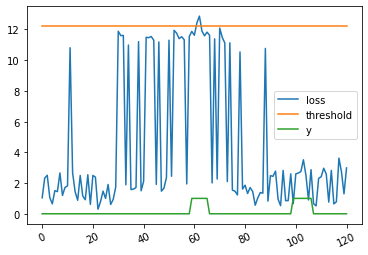

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

THRESHOLD = 12.2 # Anomaly score threshold for an instance to be considered as anomaly 

#TIME_STEPS = dataset.window_length
test_score_df = pd.DataFrame(index=range(test_dataset.data_len))
test_score_df['loss'] = [loss.item()/test_dataset.window_length for loss in loss_list]
test_score_df['y'] = test_dataset.y
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in test_dataset.x]

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.plot(test_score_df.index, test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


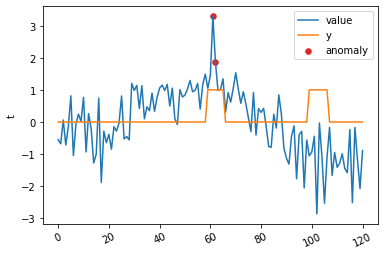

In [28]:
import seaborn as sns

anomalies = test_score_df[test_score_df.anomaly == True]

plt.plot(
  range(test_dataset.data_len), 
  test_score_df['t'], 
  label='value'
);

sns.scatterplot(
  anomalies.index,
  anomalies.t,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)

plt.plot(
  range(len(test_score_df['y'])),
  test_score_df['y'],
  label='y'
)

plt.xticks(rotation=25)
plt.legend();

### Calculate the window-based anomalies

In [34]:
import numpy as np
start_end = []
state = 0
for idx in test_score_df.index:
    if state==0 and test_score_df.loc[idx, 'y']==1:
        state=1
        start = idx
    if state==1 and test_score_df.loc[idx, 'y']==0:
        state = 0
        end = idx
        start_end.append((start, end))

for s_e in start_end:
    if sum(test_score_df[s_e[0]:s_e[1]+1]['anomaly'])>0:
        for i in range(s_e[0], s_e[1]+1):
            test_score_df.loc[i, 'anomaly'] = 1
            
actual = np.array(test_score_df['y'])
predicted = np.array([int(a) for a in test_score_df['anomaly']])

### Calculate measurement scores

In [30]:
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

tp = np.count_nonzero(predicted * actual)
tn = np.count_nonzero((predicted - 1) * (actual - 1))
fp = np.count_nonzero(predicted * (actual - 1))
fn = np.count_nonzero((predicted - 1) * actual)

print('True Positive\t', tp)
print('True Negative\t', tn)
print('False Positive\t', fp)
print('False Negative\t', fn)

accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fmeasure = (2 * precision * recall) / (precision + recall)
cohen_kappa_score = cohen_kappa_score(predicted, actual)
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predicted)
auc_val = auc(false_positive_rate, true_positive_rate)
roc_auc_val = roc_auc_score(actual, predicted)

print('Accuracy\t', accuracy)
print('Precision\t', precision)
print('Recall\t', recall)
print('f-measure\t', fmeasure)
print('cohen_kappa_score\t', cohen_kappa_score)
print('auc\t', auc_val)
print('roc_auc\t', roc_auc_val)

True Positive	 7
True Negative	 105
False Positive	 1
False Negative	 8
Accuracy	 0.9256198347107438
Precision	 0.875
Recall	 0.4666666666666667
f-measure	 0.608695652173913
cohen_kappa_score	 0.5717656311443178
auc	 0.728616352201258
roc_auc	 0.728616352201258


In [23]:
# import winsound
# frequency = 200  # Set Frequency To 2500 Hertz
# duration = 2000  # Set Duration To 1000 ms == 1 second
# winsound.Beep(frequency, duration)